<a href="https://colab.research.google.com/github/jhguay/DonneesEnMain/blob/main/ED_ExportationsAmericainesAuCanada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explorer les données**
# Les exportations américaines au Canada, 4 septembre 2025
Jean-Herman Guay, professeur émérite Université de Sherbrooke

Le journaliste Francis Vailles de La Presse a cherché à savoir si le boycott des produits américains par les Canadiens avait un effet. Il faut avant tout lire cet article: https://www.lapresse.ca/affaires/chroniques/2025-09-03/droits-de-douane-et-boycottage/l-offensive-canadienne-a-fait-des-ravages.php. L'**objectif** est ici de retrouver les données du tableau et de les traiter d'une manière analogue.


# 1. Trouver les données

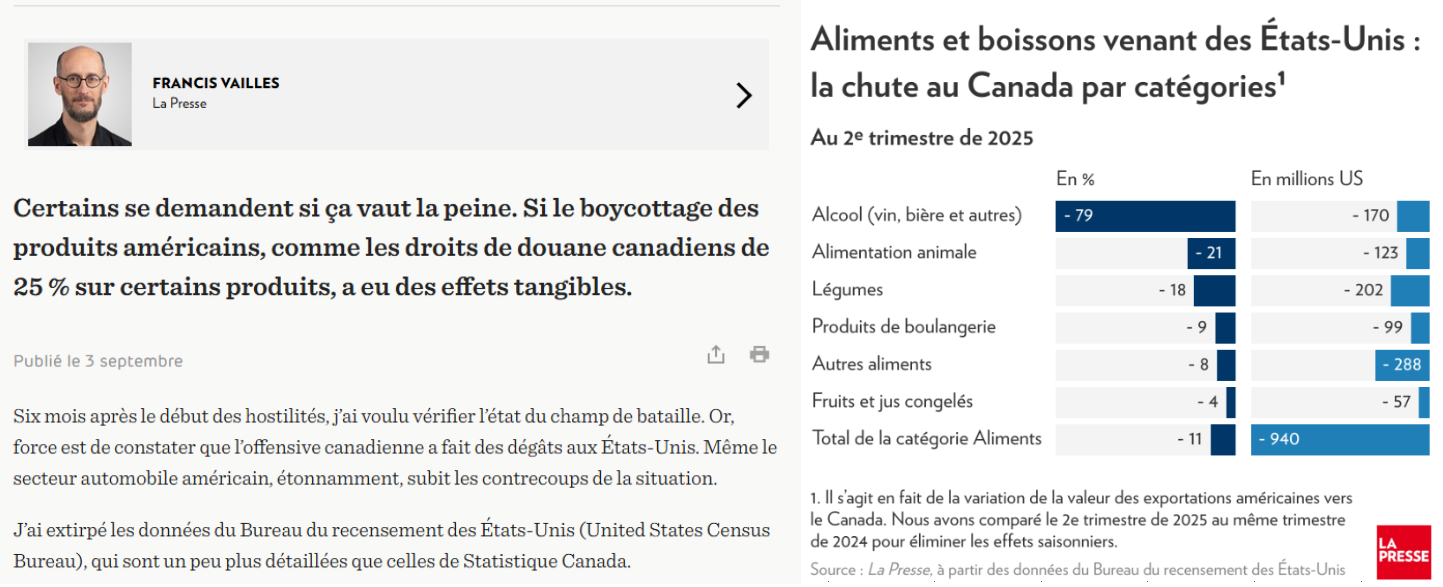

Il faut d'abord retrouver les données. Francis Vailles nous donne quatre indications précieuses, cinq en fait. Ce sont des mots clés utiles pour faire nos recherches.
1) La source **United States Census Bureau**, l'équivalent de Statistique Canada;
2) ensuite l'indicateur retenu. Dans sa note à la fin de l'article, il précise:"Les données américaines du U.S. Census Bureau que nous avons utilisées (**end-use** classification system)". Il faut donc chercher end-use classification system.
3) Aussi, il nous indique dans l'article les items qu'il entend traiter. Nous allons nous arrêter aux **Légumes**!
4) Enfin, il nous indique la comparaison. Il va comparer le second **trimestre** de 2024 (avril, mai et juin) avec le second trimestre de 2025, la guerre commerciale étant déclenchée au début de l'année 2025.
5) C'est évident, mais il faudra isoler les exportations américaines vers le **Canada**. Le Canada est peut-être associé à un code.

Pour trouver l'organisme, on utilise Google mais on ajoute le terme API.
En informatique, API veut dire Application Programming Interface (en français : interface de programmation d’applications). Une API est un ensemble de règles, de fonctions et de protocoles qui permettent à un logiciel ou un service de communiquer avec un autre.


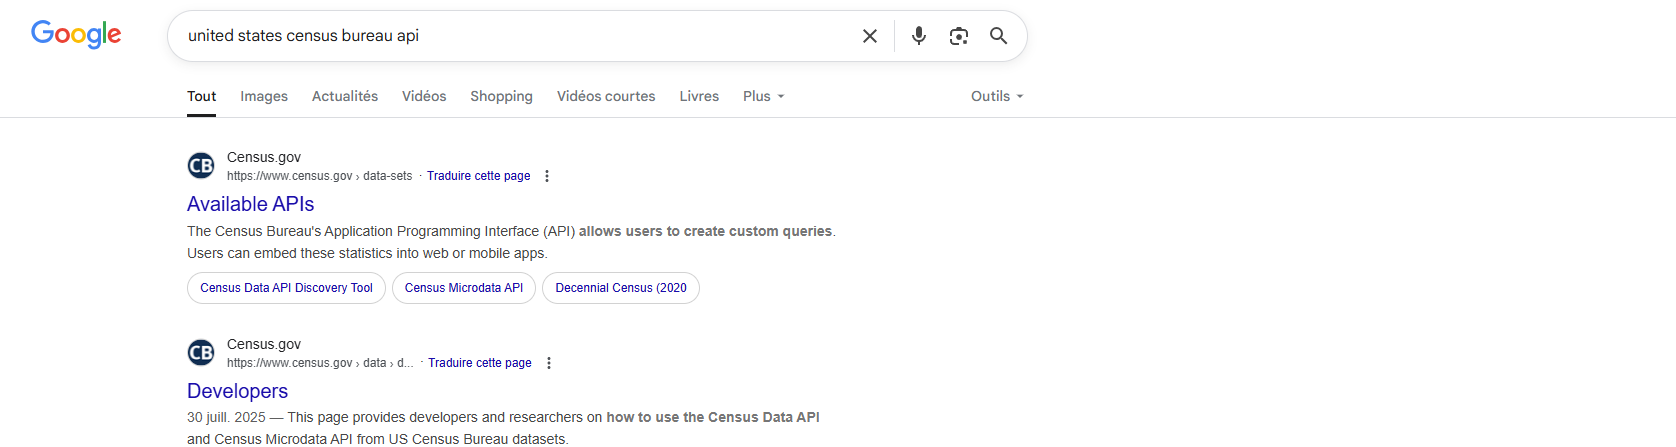

En fouillant pendant une bonne heure, j'ai fini par trouver la facon de récupérer les données. J'ai d'abord trouvé le manuel pour interroger les données: https://www.census.gov/foreign-trade/reference/guides/Guide_to_International_Trade_Datasets.pdf.
J'ai aussi trouver la liste des codes pour chacun des items: https://www.census.gov/foreign-trade/reference/codes/enduse/exeumstr.txt. À première vue, c'est un peu décourageant! Qui peut nous aider? L'intelligence artificielle est ici d'une aide précieuse.   C'est à ChatGPT qui j'ai posé les questions suivantes: comment interroger l'API du United States Census Bureau pour sur les exportations de légumes au Canada selon la classification END-USE.




Regarder la liste des produits: 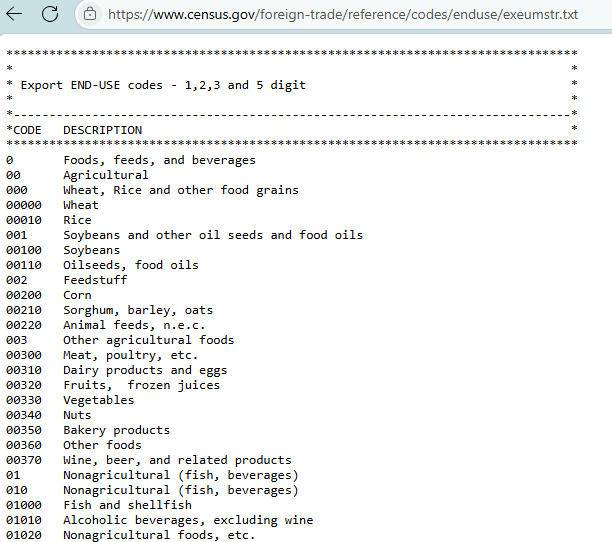

À présent, j'ai tout ce qu'il faut.

# 2. Traiter les données

In [ ]:
import requests
import pandas as pd

# Définition de la base de l'URL
base_url = "https://api.census.gov/data/timeseries/intltrade/exports/enduse"

# Paramètres,CTY_CODE, 1220 c'est le Canada, et E_ENDUSE c'est l'item choisi.
params = {
    "get": "E_ENDUSE_SDESC,ALL_VAL_MO,CTY_NAME,YEAR,MONTH",
    "CTY_CODE": "1220",
    "E_ENDUSE": "00330"
}

# Mois du deuxième trimestre 2024 et de 2025
mois = ["2024-04", "2024-05", "2024-06","2025-04", "2025-05", "2025-06"]

# Liste pour stocker les données
donnees = []

for mois_ in mois:
    params["time"] = mois_
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        donnees.extend(data[1:])  # Exclure l'en-tête
    else:
        print(f"Erreur {response.status_code} pour {mois_}")

# Convertir en DataFrame
colonnes = data[0]  # En-têtes
df = pd.DataFrame(donnees, columns=colonnes)
df


,E_ENDUSE_SDESC,ALL_VAL_MO,CTY_NAME,YEAR,MONTH,CTY_CODE,E_ENDUSE,time
0,VEGETABLES,369876349,CANADA,2024,04,1220,00330,2024-04
1,VEGETABLES,403488702,CANADA,2024,05,1220,00330,2024-05
2,VEGETABLES,345146552,CANADA,2024,06,1220,00330,2024-06
3,VEGETABLES,305475723,CANADA,2025,04,1220,00330,2025-04
4,VEGETABLES,326975151,CANADA,2025,05,1220,00330,2025-05
5,VEGETABLES,283981627,CANADA,2025,06,1220,00330,2025-06


Il me reste un travail final puisqu'il faut additionner les valeurs des mois d'avril, mai et juin pour les deux années. J'aurais pu faire cela à la main, avec ma calculatrice mais je vais jusqu'au bout pour automatiser le processus.

In [ ]:
df["ALL_VAL_MO"] = pd.to_numeric(df["ALL_VAL_MO"])
# 1️⃣ Somme des valeurs par année
totaux = df.groupby("YEAR")["ALL_VAL_MO"].sum()
print("Totaux par année :\n", totaux)


totaux = df.groupby("YEAR")[ "ALL_VAL_MO"].sum().reset_index()
totaux["YEAR"] = totaux["YEAR"].astype(int)

# Extraire les totaux par année
total_2024 = totaux.loc[totaux["YEAR"] == 2024, "ALL_VAL_MO"].values[0]
total_2025 = totaux.loc[totaux["YEAR"] == 2025, "ALL_VAL_MO"].values[0]

# Soustraction
difference = total_2025 - total_2024
differencePCT=round(difference/total_2024,2)*100
print("Différence (2025 - 2024) :", difference)
print("Différence en pct (2025 - 2024) :", differencePCT)

Totaux par année :
 YEAR
2024    1118511603
2025     916432501
Name: ALL_VAL_MO, dtype: int64
Différence (2025 - 2024) : -202079102
Différence en pct (2025 - 2024) : -18.0


Essayez avec les produits de la boulangerie (00350) ou l'alimentation animale (00220) ou les fruits et jus congelés (00320). Dans certains cas, le journaliste a probablement combiné deux items.